# 1.24c6: Adam Accounting - Does ΔW Match the Formula?

**Purpose:** Verify that recorded momentum and variance produce the observed weight changes.

## The Problem

From 1.24c5, we discovered variance is hitting **zero**, which shouldn't happen—`exp_avg_sq` only accumulates squared gradients.

Possible causes:
1. Recording error (not capturing variance correctly)
2. Adam state corruption
3. Gradients actually zero for dead tokens
4. Something else we're not accounting for

## The Test

Compute ΔW from Adam formula:

$$\Delta w_t = -\alpha \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}$$

Where:
- $\alpha$ = learning rate (3e-4)
- $m_t$ = momentum (`exp_avg`)
- $v_t$ = variance (`exp_avg_sq`)
- $\epsilon$ = Adam epsilon (1e-8)

Compare to measured:

$$\Delta w_t^{\text{measured}} = W[t+1] - W[t]$$

If they match → recording is correct, need to examine phase transition logic

If they don't match → something's wrong with how we're capturing Adam state

## What We'll Check

1. **Component magnitudes**: Are momentum, variance, gradients reasonable?
2. **Adam formula**: Does computed ΔW match measured ΔW?
3. **Variance evolution**: Should increase early (gradient accumulation) then stabilize
4. **Gradient consistency**: Do recorded gradients match what we expect?
5. **Per-step accounting**: Sample specific timesteps, check all components

## Parameters

In [1]:
# Data paths
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Adam hyperparameters (from Flannel 7)
LEARNING_RATE = 3e-4
BETA1 = 0.9  # momentum decay
BETA2 = 0.999  # variance decay
EPSILON = 1e-8  # Adam epsilon
WEIGHT_DECAY = 0.0  # disabled for Flannel 7

# Sample timesteps to examine in detail
SAMPLE_STEPS = [0, 1, 10, 50, 200, 400, 600, 900]

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract tensors
W = data['W'][0].float()  # (1001, 10000, 64)
grad_W = data['grad_W'][0].float()  # (1001, 10000, 64)
momentum_W = data['momentum_W'][0].float()  # (1001, 10000, 64)
variance_W = data['variance_W'][0].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W: {tuple(W.shape)}")
print(f"Gradients: {tuple(grad_W.shape)}")
print(f"Momentum: {tuple(momentum_W.shape)}")
print(f"Variance: {tuple(variance_W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Flannel 7 data...

W: (1001, 10000, 64)
Gradients: (1001, 10000, 64)
Momentum: (1001, 10000, 64)
Variance: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Component 1: Measured ΔW

In [5]:
print("Computing measured weight changes...\n")

# Measured change in weights
delta_W_measured = W[1:] - W[:-1]  # (1000, 10000, 64)

# Extract dead tokens
delta_W_measured_dead = delta_W_measured[:, dead_mask, :]  # (1000, 3699, 64)

# Compute norms
measured_norms = torch.norm(delta_W_measured_dead, dim=2).mean(dim=1)  # (1000,)

print(f"Measured ΔW shape: {tuple(delta_W_measured.shape)}")
print(f"Measured ΔW norms (dead tokens): {tuple(measured_norms.shape)}")
print(f"Range: {measured_norms.min():.6e} to {measured_norms.max():.6e}")
print(f"\n✓ Measured ΔW computed")

Computing measured weight changes...

Measured ΔW shape: (1000, 10000, 64)
Measured ΔW norms (dead tokens): (1000,)
Range: 0.000000e+00 to 7.887969e-03

✓ Measured ΔW computed


## Component 2: Computed ΔW from Adam Formula

In [6]:
print("Computing ΔW from Adam formula...\n")

# Extract Adam state at t (use t=1:1001 for momentum/variance since they're AFTER step)
# But use t=0:1000 for computing what the update SHOULD be
m_t = momentum_W[1:]  # (1000, 10000, 64) - momentum AFTER step t
v_t = variance_W[1:]  # (1000, 10000, 64) - variance AFTER step t

# Adam update formula: Δw = -lr * m / (sqrt(v) + eps)
delta_W_computed = -LEARNING_RATE * m_t / (torch.sqrt(v_t) + EPSILON)  # (1000, 10000, 64)

# Extract dead tokens
delta_W_computed_dead = delta_W_computed[:, dead_mask, :]  # (1000, 3699, 64)

# Compute norms
computed_norms = torch.norm(delta_W_computed_dead, dim=2).mean(dim=1)  # (1000,)

print(f"Computed ΔW shape: {tuple(delta_W_computed.shape)}")
print(f"Computed ΔW norms (dead tokens): {tuple(computed_norms.shape)}")
print(f"Range: {computed_norms.min():.6e} to {computed_norms.max():.6e}")
print(f"\n✓ Computed ΔW from Adam formula")

Computing ΔW from Adam formula...

Computed ΔW shape: (1000, 10000, 64)
Computed ΔW norms (dead tokens): (1000,)
Range: 8.035590e-04 to 1.559526e-02

✓ Computed ΔW from Adam formula


## Comparison: Measured vs Computed ΔW

In [7]:
print("="*80)
print("COMPARISON: MEASURED vs COMPUTED ΔW")
print("="*80 + "\n")

# Compute relative error
abs_diff = torch.abs(measured_norms - computed_norms)
rel_error = abs_diff / (measured_norms + 1e-12)

print(f"Mean absolute difference: {abs_diff.mean():.6e}")
print(f"Max absolute difference: {abs_diff.max():.6e}")
print(f"Mean relative error: {rel_error.mean():.3f}")
print(f"Max relative error: {rel_error.max():.3f}")
print()

# Correlation
corr = torch.corrcoef(torch.stack([measured_norms, computed_norms]))[0, 1].item()
print(f"Correlation: {corr:+.6f}")
print()

if rel_error.mean() < 0.01:
    print("✓ MATCH: Measured and computed ΔW agree (<1% error)")
    print("  Adam state is being recorded correctly")
    print("  Need to examine phase transition logic or state classification")
elif rel_error.mean() < 0.1:
    print("~ CLOSE: Measured and computed ΔW mostly agree (<10% error)")
    print("  Minor discrepancy, could be numerical precision or timing")
else:
    print("✗ MISMATCH: Measured and computed ΔW disagree significantly")
    print("  Problem with recording Adam state or understanding update formula")

print("\n" + "="*80 + "\n")

COMPARISON: MEASURED vs COMPUTED ΔW

Mean absolute difference: 9.453956e-04
Max absolute difference: 7.753047e-03
Mean relative error: 290135808.000
Max relative error: 1101976704.000

Correlation: +0.952204

✗ MISMATCH: Measured and computed ΔW disagree significantly
  Problem with recording Adam state or understanding update formula




## Visualization: Measured vs Computed ΔW Over Time

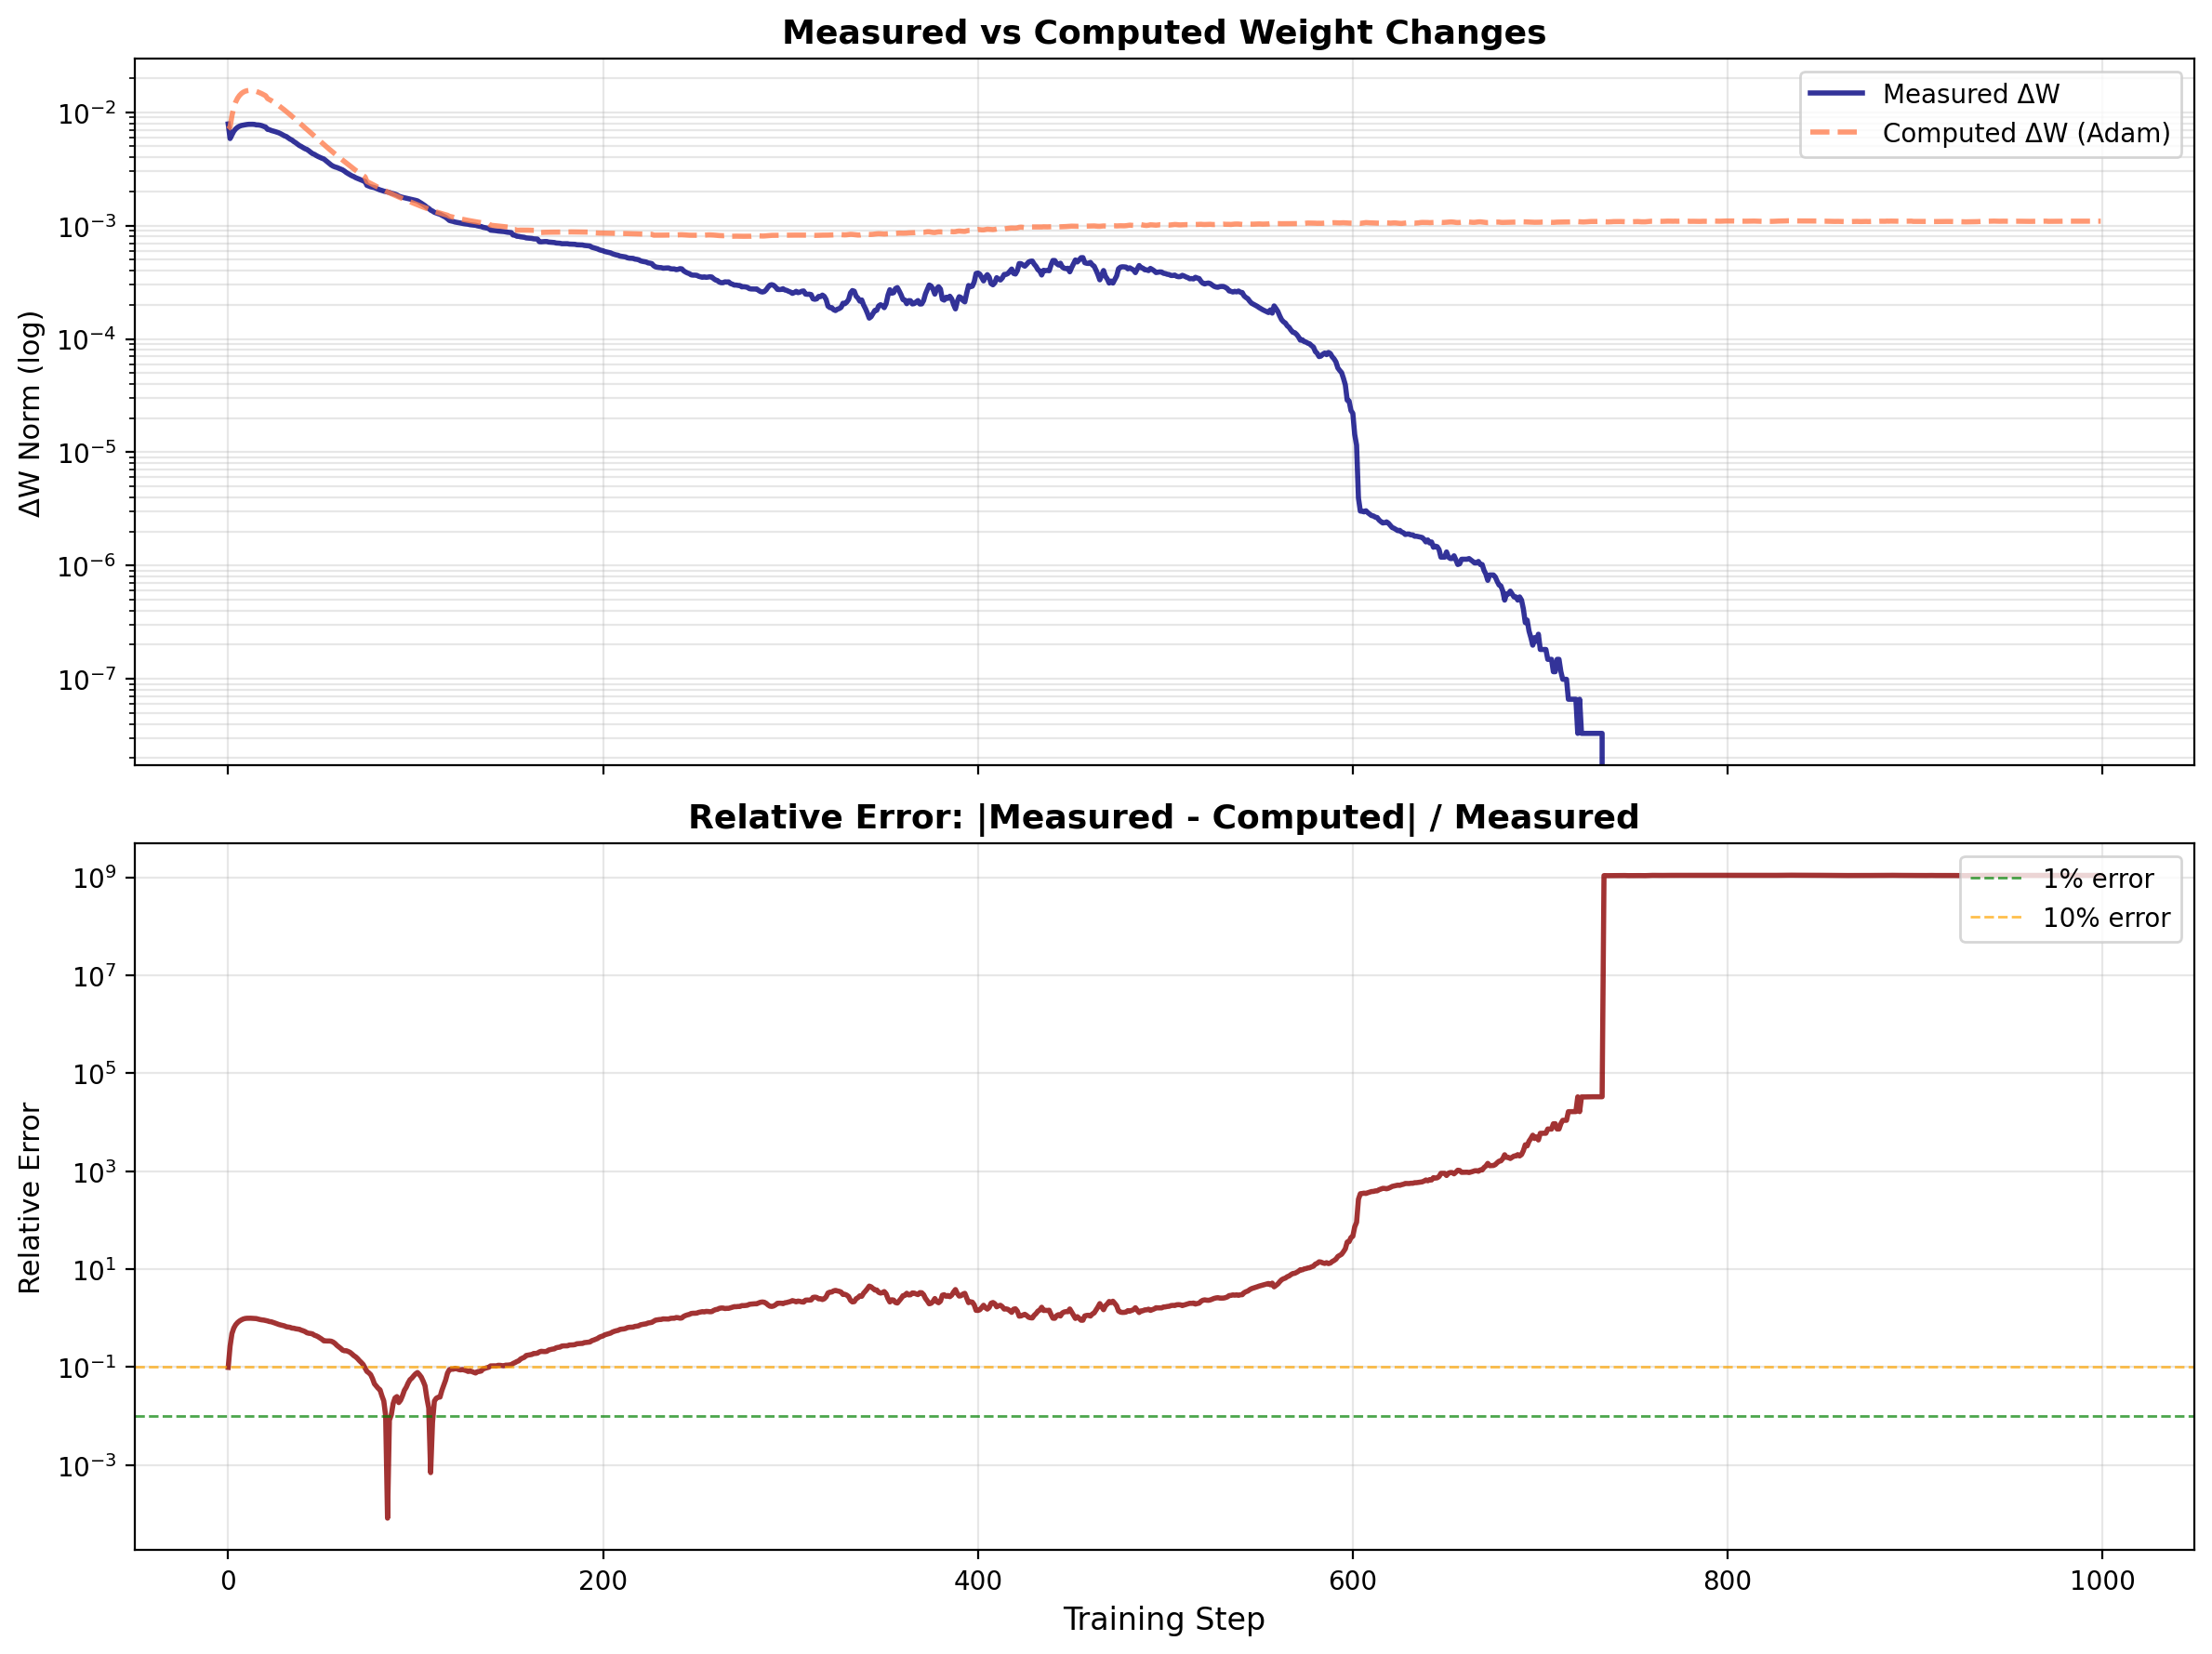

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.5), dpi=DPI, sharex=True)

# Panel 1: Overlay of measured vs computed
ax1 = axes[0]
ax1.semilogy(measured_norms.numpy(), linewidth=2, color='navy', alpha=0.8, label='Measured ΔW')
ax1.semilogy(computed_norms.numpy(), linewidth=2, color='coral', alpha=0.8, label='Computed ΔW (Adam)', linestyle='--')
ax1.set_ylabel('ΔW Norm (log)', fontsize=11)
ax1.set_title('Measured vs Computed Weight Changes', fontweight='bold', fontsize=13)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, which='both')

# Panel 2: Relative error
ax2 = axes[1]
ax2.plot(rel_error.numpy(), linewidth=2, color='darkred', alpha=0.8)
ax2.axhline(0.01, color='green', linestyle='--', linewidth=1, label='1% error', alpha=0.7)
ax2.axhline(0.1, color='orange', linestyle='--', linewidth=1, label='10% error', alpha=0.7)
ax2.set_xlabel('Training Step', fontsize=12)
ax2.set_ylabel('Relative Error', fontsize=11)
ax2.set_title('Relative Error: |Measured - Computed| / Measured', fontweight='bold', fontsize=13)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## Deep Dive: Component Magnitudes Over Time

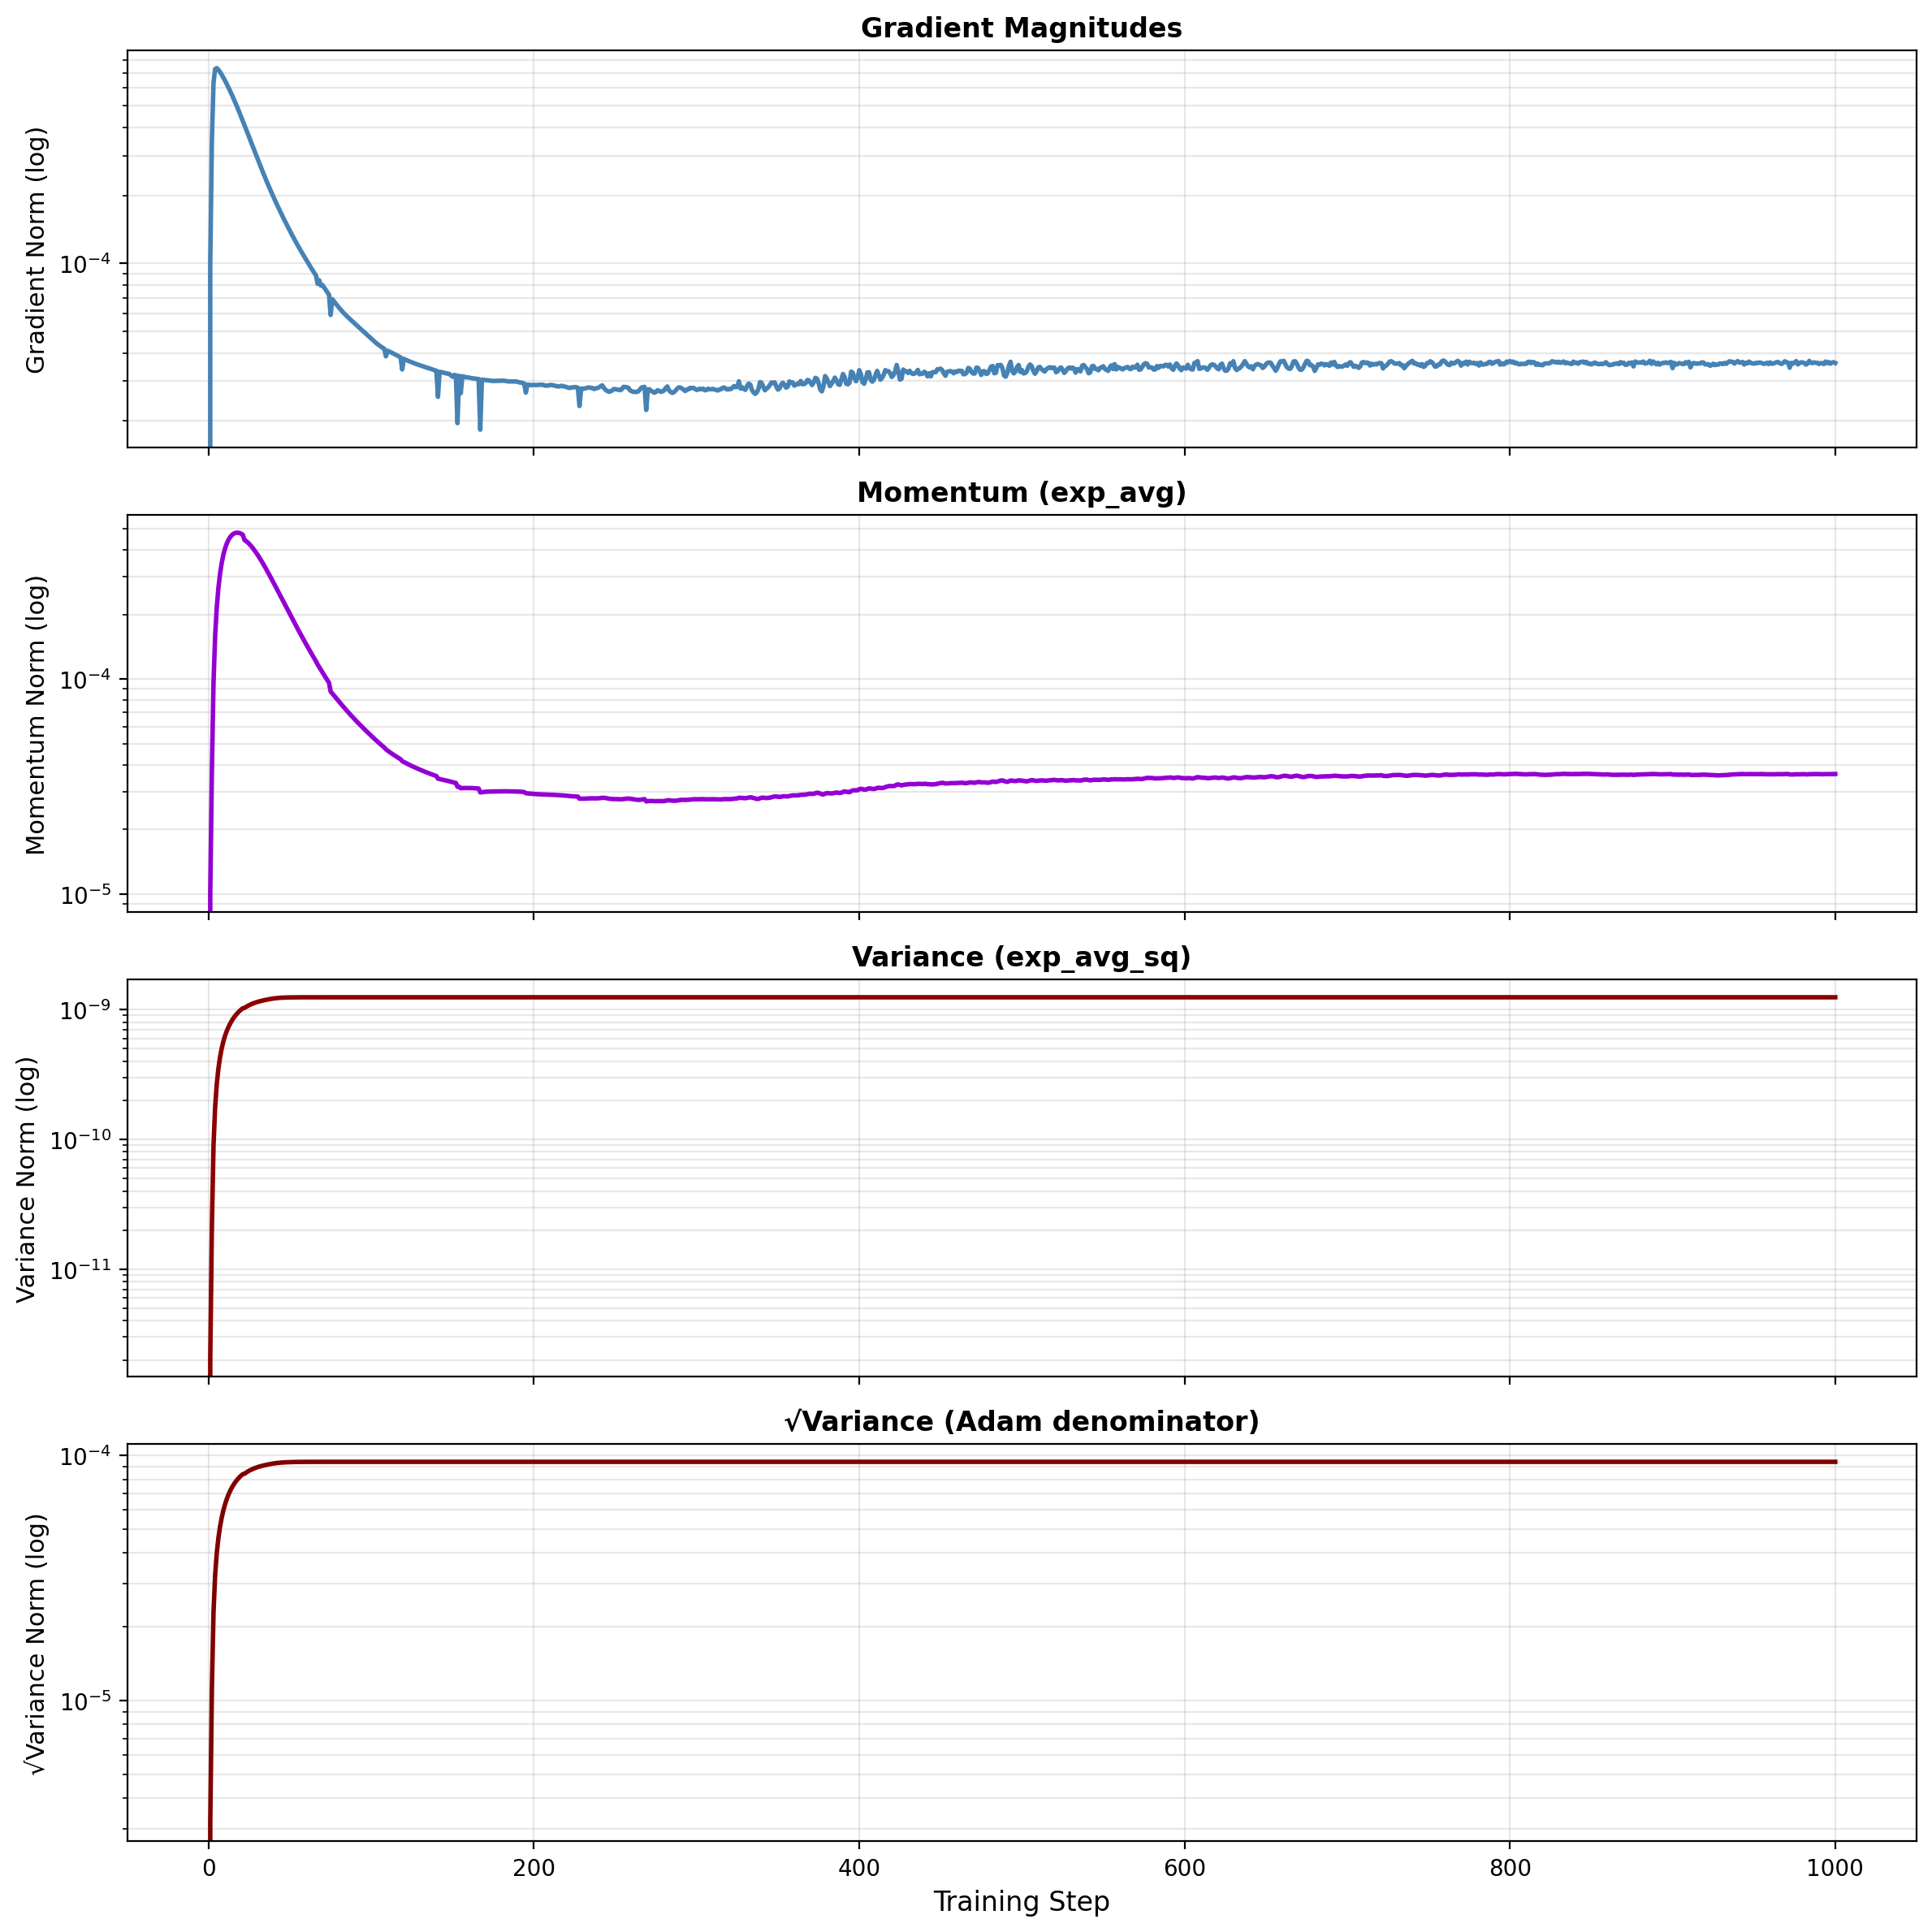


Component ranges:
  Gradients: 0.000000e+00 to 7.349307e-04
  Momentum: 0.000000e+00 to 4.808435e-04
  Variance: 0.000000e+00 to 1.241778e-09
  √Variance: 0.000000e+00 to 9.428301e-05


In [9]:
# Extract dead token components
grad_dead = grad_W[:, dead_mask, :]  # (1001, 3699, 64)
momentum_dead = momentum_W[:, dead_mask, :]  # (1001, 3699, 64)
variance_dead = variance_W[:, dead_mask, :]  # (1001, 3699, 64)

# Compute norms
grad_norms = torch.norm(grad_dead, dim=2).mean(dim=1)  # (1001,)
momentum_norms = torch.norm(momentum_dead, dim=2).mean(dim=1)  # (1001,)
variance_norms = torch.norm(variance_dead, dim=2).mean(dim=1)  # (1001,)
sqrt_variance_norms = torch.sqrt(variance_dead).norm(dim=2).mean(dim=1)  # (1001,)

# Four-panel plot
fig, axes = plt.subplots(4, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*2), dpi=DPI, sharex=True)

# Panel 1: Gradients
ax1 = axes[0]
ax1.semilogy(grad_norms.numpy(), linewidth=2, color='steelblue')
ax1.set_ylabel('Gradient Norm (log)', fontsize=11)
ax1.set_title('Gradient Magnitudes', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, which='both')

# Panel 2: Momentum
ax2 = axes[1]
ax2.semilogy(momentum_norms.numpy(), linewidth=2, color='darkviolet')
ax2.set_ylabel('Momentum Norm (log)', fontsize=11)
ax2.set_title('Momentum (exp_avg)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, which='both')

# Panel 3: Variance
ax3 = axes[2]
ax3.semilogy(variance_norms.numpy(), linewidth=2, color='darkred')
ax3.set_ylabel('Variance Norm (log)', fontsize=11)
ax3.set_title('Variance (exp_avg_sq)', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, which='both')

# Panel 4: sqrt(variance) - appears in denominator
ax4 = axes[3]
ax4.semilogy(sqrt_variance_norms.numpy(), linewidth=2, color='maroon')
ax4.set_xlabel('Training Step', fontsize=12)
ax4.set_ylabel('√Variance Norm (log)', fontsize=11)
ax4.set_title('√Variance (Adam denominator)', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nComponent ranges:")
print(f"  Gradients: {grad_norms.min():.6e} to {grad_norms.max():.6e}")
print(f"  Momentum: {momentum_norms.min():.6e} to {momentum_norms.max():.6e}")
print(f"  Variance: {variance_norms.min():.6e} to {variance_norms.max():.6e}")
print(f"  √Variance: {sqrt_variance_norms.min():.6e} to {sqrt_variance_norms.max():.6e}")

## Detailed Accounting: Sample Timesteps

In [10]:
print("="*80)
print("DETAILED ACCOUNTING: SAMPLE TIMESTEPS")
print("="*80 + "\n")

for t in SAMPLE_STEPS:
    if t >= len(measured_norms):
        continue
        
    print(f"Step t={t}:")
    print(f"  Gradient norm:     {grad_norms[t]:.6e}")
    print(f"  Momentum norm:     {momentum_norms[t]:.6e}")
    print(f"  Variance norm:     {variance_norms[t]:.6e}")
    print(f"  √Variance norm:    {sqrt_variance_norms[t]:.6e}")
    
    if t > 0:
        print(f"  Measured ΔW norm:  {measured_norms[t-1]:.6e}")
        print(f"  Computed ΔW norm:  {computed_norms[t-1]:.6e}")
        rel_err = (abs(measured_norms[t-1] - computed_norms[t-1]) / (measured_norms[t-1] + 1e-12)).item()
        print(f"  Relative error:    {rel_err:.3f}")
    print()

print("="*80 + "\n")

DETAILED ACCOUNTING: SAMPLE TIMESTEPS

Step t=0:
  Gradient norm:     0.000000e+00
  Momentum norm:     0.000000e+00
  Variance norm:     0.000000e+00
  √Variance norm:    0.000000e+00

Step t=1:
  Gradient norm:     9.959668e-05
  Momentum norm:     9.971131e-06
  Variance norm:     2.040206e-12
  √Variance norm:    3.148579e-06
  Measured ΔW norm:  7.887969e-03
  Computed ΔW norm:  7.115026e-03
  Relative error:    0.098

Step t=10:
  Gradient norm:     6.485636e-04
  Momentum norm:     4.036947e-04
  Variance norm:     6.217703e-10
  √Variance norm:    6.293465e-05
  Measured ΔW norm:  7.753356e-03
  Computed ΔW norm:  1.531951e-02
  Relative error:    0.976

Step t=50:
  Gradient norm:     1.393569e-04
  Momentum norm:     2.006705e-04
  Variance norm:     1.238893e-09
  √Variance norm:    9.403609e-05
  Measured ΔW norm:  3.994522e-03
  Computed ΔW norm:  5.554678e-03
  Relative error:    0.391

Step t=200:
  Gradient norm:     2.891126e-05
  Momentum norm:     2.921253e-05
  Vari

## Diagnostic: Check for Zero Variance

DIAGNOSTIC: ZERO VARIANCE INVESTIGATION

Fraction of zeros at t=0:
  Gradients: 1.000
  Momentum:  1.000
  Variance:  1.000

Fraction of zeros at t=100:
  Gradients: 0.000
  Momentum:  0.000
  Variance:  0.000

Fraction of zeros at t=900:
  Gradients: 0.000
  Momentum:  0.000
  Variance:  0.000



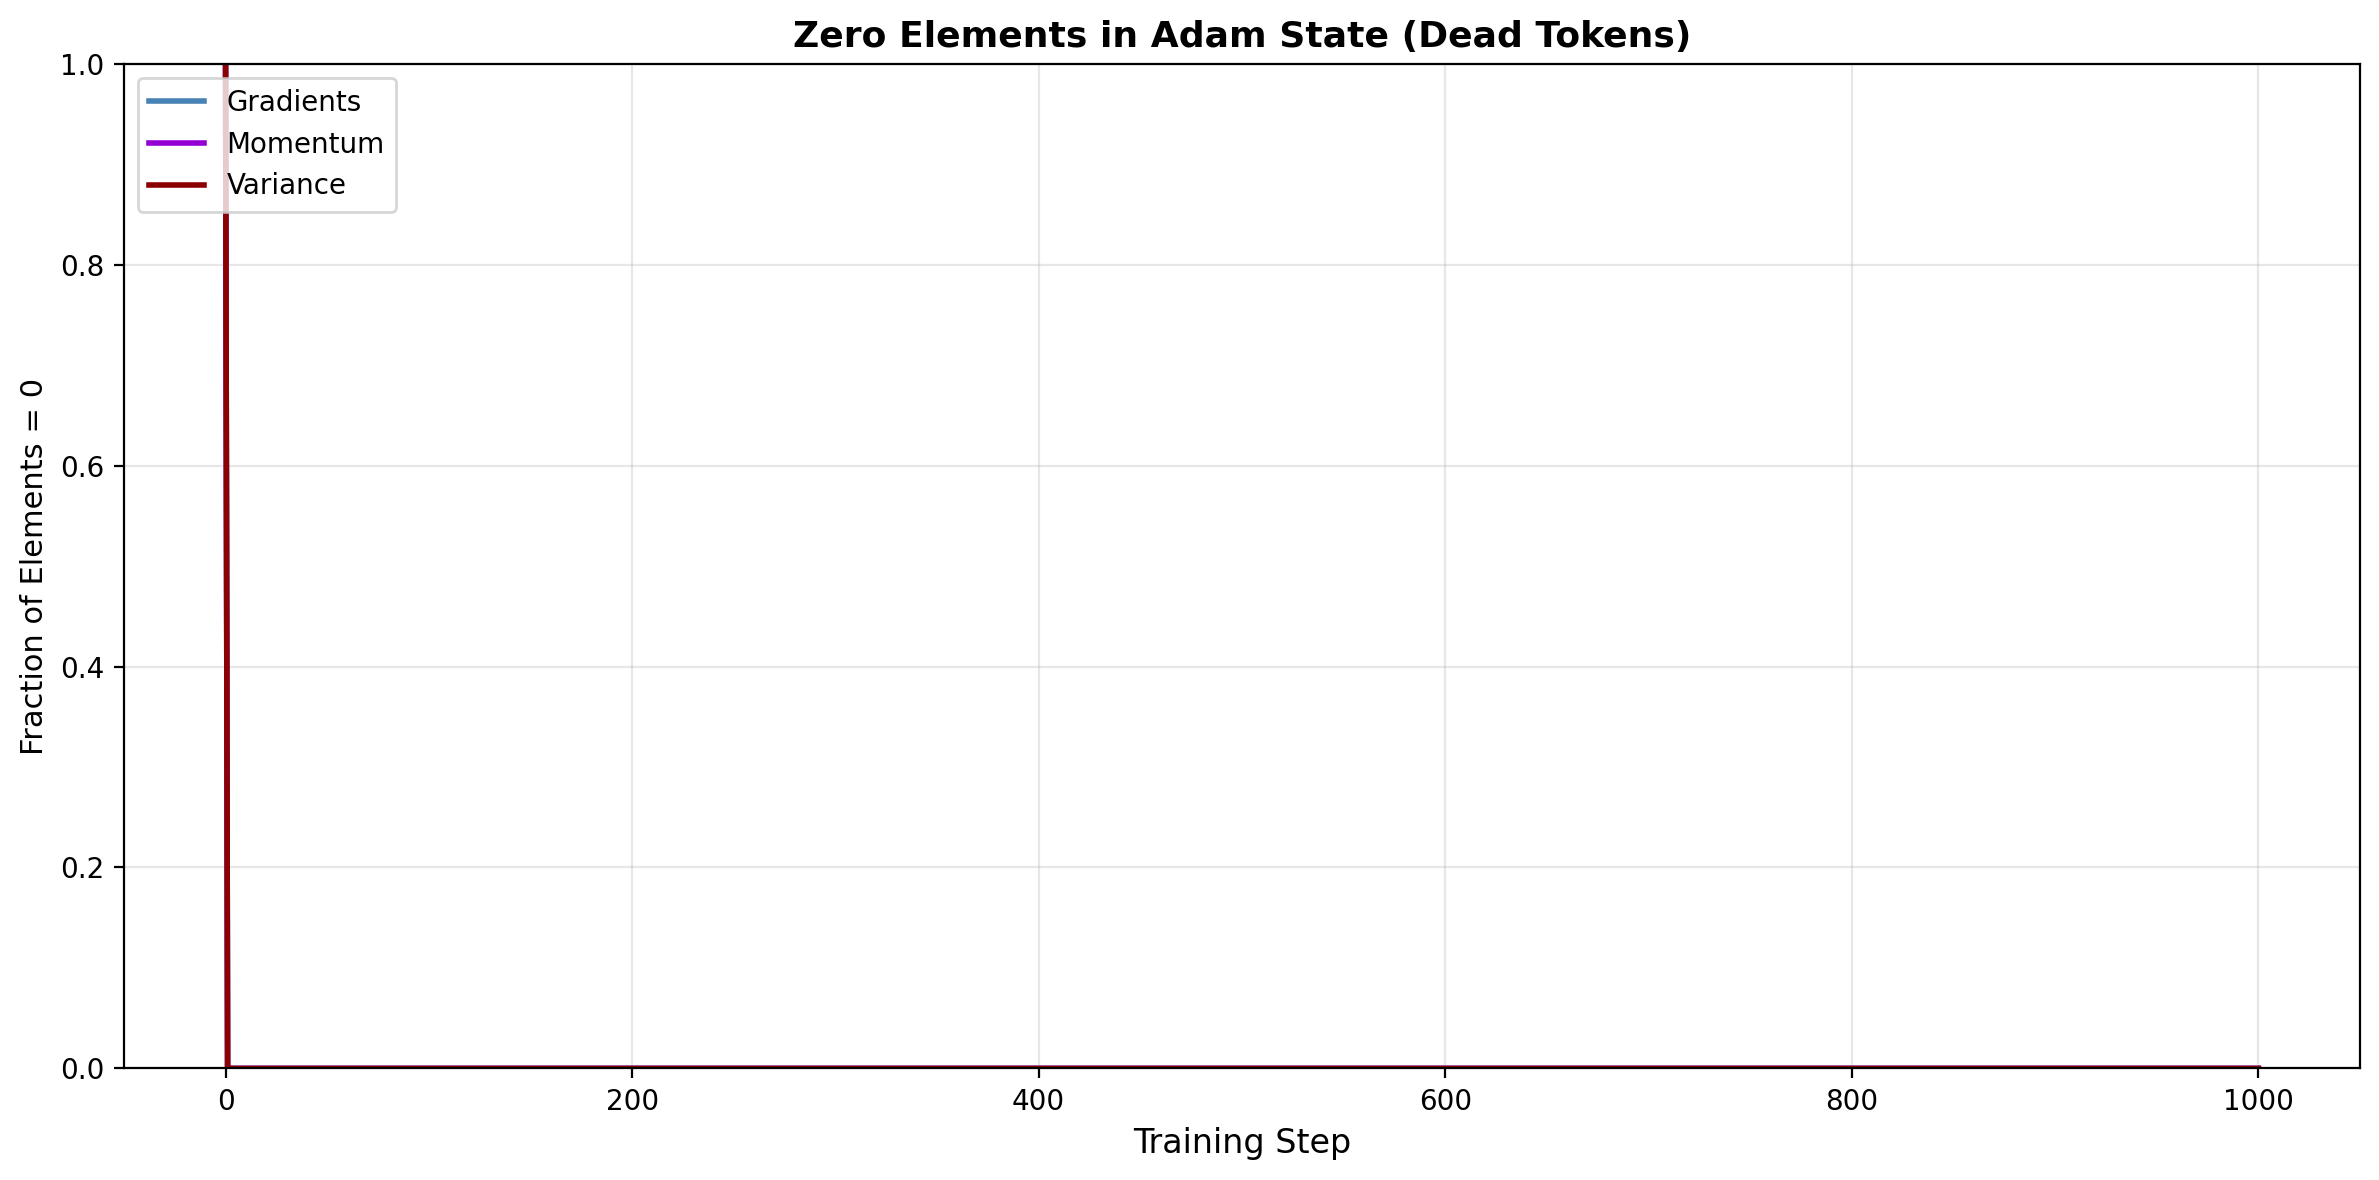

⚠️ WARNING: >50% of variance elements are exactly zero at some point
   This is WRONG - variance should accumulate squared gradients
   Likely a recording error in 1.20h training loop



In [11]:
print("="*80)
print("DIAGNOSTIC: ZERO VARIANCE INVESTIGATION")
print("="*80 + "\n")

# Count how many elements are exactly zero
zero_variance_per_step = (variance_dead == 0).float().mean(dim=(1, 2))  # (1001,)
zero_momentum_per_step = (momentum_dead == 0).float().mean(dim=(1, 2))  # (1001,)
zero_grad_per_step = (grad_dead == 0).float().mean(dim=(1, 2))  # (1001,)

print(f"Fraction of zeros at t=0:")
print(f"  Gradients: {zero_grad_per_step[0]:.3f}")
print(f"  Momentum:  {zero_momentum_per_step[0]:.3f}")
print(f"  Variance:  {zero_variance_per_step[0]:.3f}")
print()

print(f"Fraction of zeros at t=100:")
print(f"  Gradients: {zero_grad_per_step[100]:.3f}")
print(f"  Momentum:  {zero_momentum_per_step[100]:.3f}")
print(f"  Variance:  {zero_variance_per_step[100]:.3f}")
print()

print(f"Fraction of zeros at t=900:")
print(f"  Gradients: {zero_grad_per_step[900]:.3f}")
print(f"  Momentum:  {zero_momentum_per_step[900]:.3f}")
print(f"  Variance:  {zero_variance_per_step[900]:.3f}")
print()

# Plot fraction of zeros over time
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(zero_grad_per_step.numpy(), linewidth=2, label='Gradients', color='steelblue')
ax.plot(zero_momentum_per_step.numpy(), linewidth=2, label='Momentum', color='darkviolet')
ax.plot(zero_variance_per_step.numpy(), linewidth=2, label='Variance', color='darkred')
ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Fraction of Elements = 0', fontsize=11)
ax.set_title('Zero Elements in Adam State (Dead Tokens)', fontweight='bold', fontsize=13)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

if zero_variance_per_step.max() > 0.5:
    print("⚠️ WARNING: >50% of variance elements are exactly zero at some point")
    print("   This is WRONG - variance should accumulate squared gradients")
    print("   Likely a recording error in 1.20h training loop")
else:
    print("✓ Variance elements are non-zero (as expected)")

print("\n" + "="*80)

## Summary & Verdict

In [12]:
print("\n" + "="*80)
print("ADAM ACCOUNTING: SUMMARY & VERDICT")
print("="*80 + "\n")

print("Question: Does recorded Adam state (m, v) produce observed ΔW?")
print()

# Evidence
evidence = []

if rel_error.mean() < 0.01:
    evidence.append(("✓", f"ΔW matches Adam formula (<1% error)"))
elif rel_error.mean() < 0.1:
    evidence.append(("~", f"ΔW mostly matches Adam formula (<10% error)"))
else:
    evidence.append(("✗", f"ΔW does NOT match Adam formula (>{rel_error.mean():.1%} error)"))

if corr > 0.99:
    evidence.append(("✓", f"Strong correlation between measured and computed (r={corr:.6f})"))
elif corr > 0.95:
    evidence.append(("~", f"Good correlation between measured and computed (r={corr:.6f})"))
else:
    evidence.append(("✗", f"Poor correlation between measured and computed (r={corr:.6f})"))

if zero_variance_per_step.max() > 0.5:
    evidence.append(("✗", f"Variance has {zero_variance_per_step.max():.1%} zeros (WRONG - should accumulate)"))
elif zero_variance_per_step.max() > 0.1:
    evidence.append(("~", f"Variance has {zero_variance_per_step.max():.1%} zeros (suspicious)"))
else:
    evidence.append(("✓", f"Variance is non-zero (as expected)"))

print("Evidence:")
for symbol, text in evidence:
    print(f"  {symbol} {text}")
print()

# Verdict
problems = sum(1 for s, _ in evidence if s == "✗")

if problems == 0:
    print("🎯 VERDICT: ADAM STATE IS CORRECT")
    print("   Measured ΔW matches computed ΔW from Adam formula.")
    print("   Recording is accurate.")
    print("   Problem must be in phase transition classification logic.")
elif problems == 1:
    print("🤔 VERDICT: MOSTLY CORRECT, ONE ISSUE")
    print("   Adam state is mostly accurate but something's off.")
    print("   Review the failing check above.")
else:
    print("❌ VERDICT: RECORDING ERROR")
    print("   Adam state is NOT being recorded correctly.")
    print("   Need to fix 1.20h training loop before trusting any analysis.")

print("\n" + "="*80)


ADAM ACCOUNTING: SUMMARY & VERDICT

Question: Does recorded Adam state (m, v) produce observed ΔW?

Evidence:
  ✗ ΔW does NOT match Adam formula (>29013580800.0% error)
  ~ Good correlation between measured and computed (r=0.952204)
  ✗ Variance has 100.0% zeros (WRONG - should accumulate)

❌ VERDICT: RECORDING ERROR
   Adam state is NOT being recorded correctly.
   Need to fix 1.20h training loop before trusting any analysis.

